In [34]:
import os
import cv2
import math
import json
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
from collections import namedtuple
from matplotlib import pyplot as plt
import itertools
 

# Parsing all forensic labels

- Read the file from MongoDB that includes all tags
- Used bash to get the ones with polygonoal selection: cat /home/mousavi/exportsFromMongo/tags/tags.csv.20210523 | grep poly > tags.csv.20210523.poly
- Cleaned the tags by having each tag in one line (before they were multiple per line, separated by ;), and lower case


In [60]:
filename = "/data/sara/DecompositionFeatureSegmentation/data/tags.csv.20210523.poly"
df = pd.read_csv(filename ,  delimiter = ',', names = ['_id', 'user', 'location', 'image', 'tag', 'created', '__v'])

In [62]:
clean_df = pd.DataFrame()
for index, row in df.iterrows():
    tags = row['tag'].split(';')
    for tag in tags:
        row['tag'] = tag.lower().strip()
        clean_df = clean_df.append(row)


In [63]:
len(clean_df['tag'].unique())

131

### Get one hot encoding for each image
- For each image, check all labels that it has
- Create a new dataframe to keep this information

In [70]:
classes = {val:[] for val in clean_df['tag'].unique()}
df_decom_classes = pd.DataFrame()
image_ids = []
image_paths = []

for index, row in df.iterrows():
    img_name = row['image'].split('/')[-1]
    img_path = "/usb/sara_img/" + img_name
    img_id = img_name.split('.')[0]
    
    if img_id not in image_ids:
        image_ids.append(img_id)
        image_paths.append(img_path)
        tmp_classes = df[df['image'] == row['image']]['tag'].unique()

        for k, v in classes.items():
            if k in tmp_classes:
                classes[k].append(1)
            else:
                classes[k].append(0)
            
df_decom_classes['id'] = image_ids
df_decom_classes['image_path'] = image_paths

for k, v in classes.items():
    df_decom_classes[k] = classes[k]
    

In [71]:
df_decom_classes.to_csv("../data/bodyparts_csv/all_decom_labels.csv")

# Getting the decom data for bodyparts

In [91]:
train_imgs = "/data/sara/semantic-segmentation-pytorch/data/train.odgt"
val_imgs = "/data/sara/semantic-segmentation-pytorch/data/val.odgt"
test_imgs = "/data/sara/semantic-segmentation-pytorch/data/test.odgt"

In [35]:
BODY_CLASSES = [
    "background",
    "foot",
    "hand",
    "arm",
    "leg",
    "torso",
    "head"
]

ANN_ROOT_DIR = "/data/sara/semantic-segmentation-pytorch/"

random.seed(0)
NUM_CLASSES = 7
BODY_COLORMAP = [(random.randint(0, 255), random.randint(
    0, 255), random.randint(0, 255)) for _ in range(NUM_CLASSES)]

In [106]:
def get_classes_names(path, class_names):
    gray = cv2.imread(path, 0)
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret_list = []
    for i in np.unique(gray): ret_list.append(class_names[i])
    return ret_list

In [107]:
filenames = [train_imgs, val_imgs, test_imgs]
modes = ['train', 'val', 'test']
for idx, filename in enumerate(filenames):
    with open(filename, 'r') as f:
        data = f.readlines()

    dict_data = [json.loads(val) for val in data]
    df = pd.DataFrame(dict_data)


    # dict of classes. 1:contain class, 0:NO class
    classes = {val:[] for val in BODY_CLASSES}
    image_ids = []

    for index, row in df.iterrows():
        label_path = ANN_ROOT_DIR + row['fpath_segm']
        img_id = label_path.split('/')[-1].split('.')[0]

        image_ids.append(img_id)
        tmp_classes = get_classes_names(label_path, BODY_CLASSES)

        for k, v in classes.items():
            if k in tmp_classes:
                classes[k].append(1)
            else:
                classes[k].append(0)

    df['id'] = image_ids

    for k, v in classes.items():
        df[k] = classes[k]
    df.to_csv("../data/bodyparts_csv/" + modes[idx] + ".csv")

# Analysis

In [118]:
def transparent_overlays(image, annotation, alpha=0.5):
    img1 = image.copy()
    img2 = annotation.copy()

    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols ]

    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Now black-out the area of logo in ROI
    # img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

    # Put logo in ROI and modify the main image
    # dst = cv2.add(img1_bg, img2_fg)
    dst = cv2.addWeighted(image.copy(), 1-alpha, img2_fg, alpha, 0)
    img1[0:rows, 0:cols ] = dst
    return dst

def color_im(img, colors):
    for i in range(len(colors)):
        img[:,:,0][np.where(img[:,:,0] == i)] = colors[i][0]
        img[:,:,1][np.where(img[:,:,1] == i)] = colors[i][1]
        img[:,:,2][np.where(img[:,:,2] == i)] = colors[i][2]
    return img

def vis_pair(img1, img2, label1, label2):
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    label1 = cv2.imread(label1)

    label2 = cv2.imread(label2)
    
    tmp_label2 = cv2.resize(label2, (int(label1.shape[1]), int(label1.shape[0])))
    
    label1[np.where(label1 == 0)] = 255 # to exclude the bg from intersection
    
    intersection = np.where(label1[:,:,0] == tmp_label2[:,:,0])[0].shape[0]
    union = np.where(label1[:,:,0] != 255 )[0].shape[0] + np.where(tmp_label2[:,:,0] != 0 )[0].shape[0] - intersection
    '''
    plt.figure(figsize=(10, 7))
    plt.imshow(img1)
    plt.show()
    
    plt.figure(figsize=(10, 7))
    plt.imshow(img2)
    plt.show()
    
    
    plt.figure(figsize=(10, 7))
    plt.imshow(transparent_overlays(color_im(label1, colors), color_im(tmp_label2, colors), 0.45))
    plt.show()
    '''

    return intersection/union



In [ ]:
df = pd.read_csv("../data/bodyparts_csv/train.csv")
colors = BODY_COLORMAP

output = ""

for i, c in enumerate(BODY_CLASSES):
    if c != 'background':
        #print(c)
        sub_data = df[df[c]==1]
        #print(f"numbers of image: {len(sub_data)} \n\n")
        count = 0
        for pair in itertools.combinations(sub_data['fpath_img'],2):
            row1 = df[df['fpath_img']==pair[0]]
            row2 = df[df['fpath_img']==pair[1]]
            imgs = [row1['fpath_img'].values[0],row2['fpath_img'].values[0]]
            segms = [ANN_ROOT_DIR + row1['fpath_segm'].values[0], ANN_ROOT_DIR + row2['fpath_segm'].values[0]]

            w, h =  row1['width'].values[0], row1['height'].values[0]

            iou = vis_pair(imgs[0], imgs[1], segms[0], segms[1])
            #if iou > 0.5 :
            new_line = {}
            new_line["fpath_img"], new_line["fpath_segm"], new_line["width"], new_line["height"], new_line['iou'] = \
                    imgs, segms, int(w), int(h), iou
            #print(new_line)
            output += json.dumps(new_line) + "\n"
        

with open('../data/bodyparts_csv/train_iou.odgt', 'w') as fp:
    fp.write(output)
    

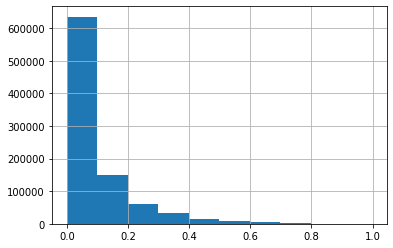

In [2]:
df_pairs = pd.read_json('../data/bodyparts_csv/train_iou.odgt', lines=True)
df_pairs['iou'].hist()
df_pairs[df_pairs['iou'] > 0.5]['iou'].hist()

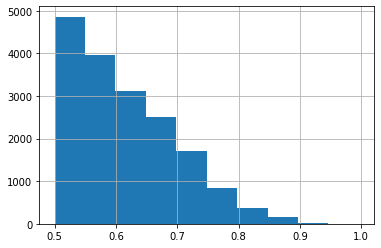

In [5]:
df_pairs[df_pairs['iou'] > 0.5]['iou'].hist()

In [ ]:
output

# Example

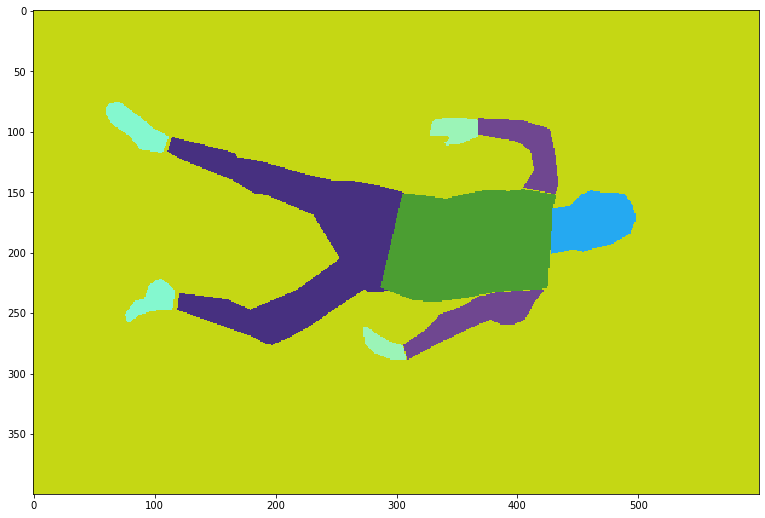

In [74]:
def color_im(img, colors):
    for i in range(len(colors)):
        img[:,:,0][np.where(img[:,:,0] == i)] = colors[i][0]
        img[:,:,1][np.where(img[:,:,1] == i)] = colors[i][1]
        img[:,:,2][np.where(img[:,:,2] == i)] = colors[i][2]
    return img

img_path = "/data/sara/semantic-segmentation-pytorch/all_body_part_annotations/29800522.14.png"

colored_seg = cv2.imread(img_path)
plt.figure(figsize=(13, 13))
plt.imshow(color_im(colored_seg,BODY_COLORMAP))
plt.show()

# get images with exact same classes

In [167]:
df = pd.read_csv("../data/bodyparts_csv/train.csv")
temp = df.groupby(by=BODY_CLASSES).size().reset_index(name='count')
temp = temp[temp['count'] > 1]
for idx, line in temp.iterrows():
    #temp = temp.set_index(BODY_CLASSES)
    temp2 = line.to_frame().transpose()
    temp2 = temp2.set_index(BODY_CLASSES)

    df2 = df[df.apply(lambda row: tuple(row[BODY_CLASSES].values) in temp2.index, axis=1)].reset_index()
    print(df2)
    break

    index  Unnamed: 0                                   fpath_img  \
0      39          39  /usb/seq_data_for_mit_code/c0f00924.57.JPG   
1      90          90  /usb/seq_data_for_mit_code/e4701108.72.JPG   
2     118         118  /usb/seq_data_for_mit_code/e4701109.70.JPG   
3     130         130  /usb/seq_data_for_mit_code/24300510.01.JPG   
4     138         138  /usb/seq_data_for_mit_code/e4701108.69.JPG   
5     250         250  /usb/seq_data_for_mit_code/07b00123.01.JPG   
6     322         322  /usb/seq_data_for_mit_code/4e510107.01.JPG   
7     392         392  /usb/seq_data_for_mit_code/a8b00827.47.JPG   
8     399         399  /usb/seq_data_for_mit_code/07b00122.02.JPG   
9     407         407  /usb/seq_data_for_mit_code/07b00122.01.JPG   
10    441         441  /usb/seq_data_for_mit_code/60810325.36.JPG   
11    460         460  /usb/seq_data_for_mit_code/5fc10414.29.JPG   
12    489         489  /usb/seq_data_for_mit_code/d7700706.26.JPG   
13    603         603  /usb/seq_da

In [163]:
df = pd.read_csv("../data/bodyparts_csv/train.csv")

In [175]:
[i for i in zip(df2['fpath_img'].values,df2['fpath_segm'].values)]

[('/usb/seq_data_for_mit_code/c0f00924.57.JPG',
  'all_body_part_annotations/c0f00924.57.png'),
 ('/usb/seq_data_for_mit_code/e4701108.72.JPG',
  'all_body_part_annotations/e4701108.72.png'),
 ('/usb/seq_data_for_mit_code/e4701109.70.JPG',
  'all_body_part_annotations/e4701109.70.png'),
 ('/usb/seq_data_for_mit_code/24300510.01.JPG',
  'all_body_part_annotations/24300510.01.png'),
 ('/usb/seq_data_for_mit_code/e4701108.69.JPG',
  'all_body_part_annotations/e4701108.69.png'),
 ('/usb/seq_data_for_mit_code/07b00123.01.JPG',
  'all_body_part_annotations/07b00123.01.png'),
 ('/usb/seq_data_for_mit_code/4e510107.01.JPG',
  'all_body_part_annotations/4e510107.01.png'),
 ('/usb/seq_data_for_mit_code/a8b00827.47.JPG',
  'all_body_part_annotations/a8b00827.47.png'),
 ('/usb/seq_data_for_mit_code/07b00122.02.JPG',
  'all_body_part_annotations/07b00122.02.png'),
 ('/usb/seq_data_for_mit_code/07b00122.01.JPG',
  'all_body_part_annotations/07b00122.01.png'),
 ('/usb/seq_data_for_mit_code/60810325.3

In [173]:
df2['fpath_segm'].values

array(['all_body_part_annotations/c0f00924.57.png',
       'all_body_part_annotations/e4701108.72.png',
       'all_body_part_annotations/e4701109.70.png',
       'all_body_part_annotations/24300510.01.png',
       'all_body_part_annotations/e4701108.69.png',
       'all_body_part_annotations/07b00123.01.png',
       'all_body_part_annotations/4e510107.01.png',
       'all_body_part_annotations/a8b00827.47.png',
       'all_body_part_annotations/07b00122.02.png',
       'all_body_part_annotations/07b00122.01.png',
       'all_body_part_annotations/60810325.36.png',
       'all_body_part_annotations/5fc10414.29.png',
       'all_body_part_annotations/d7700706.26.png',
       'all_body_part_annotations/0fd10413.30.png',
       'all_body_part_annotations/15101212.23.png',
       'all_body_part_annotations/2f900429.18.png',
       'all_body_part_annotations/59800916.24.png',
       'all_body_part_annotations/59801113.16.png',
       'all_body_part_annotations/6a701121.21.png',
       'all_

In [170]:
print(zip(a,b))

In [177]:
list(df.columns)[6:]

['background', 'foot', 'hand', 'arm', 'leg', 'torso', 'head']